<a href="https://colab.research.google.com/github/prithwis/AGI/blob/main/Chandrayaan_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)<br>


![alt text](https://github.com/Praxis-QR/RDWH/raw/main/images/YantraJaalBanner.png)<br>




[Prithwis Mukerjee](http://www.linkedin.com/in/prithwis)<br>

# ChandraYaan

In [1]:
# 1. Update package list and install the NEW opengl names
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb ffmpeg freeglut3-dev python3-opengl libgl1-mesa-dev libglu1-mesa-dev mesa-utils > /dev/null 2>&1

# 2. Install the system dependencies (SWIG is the key here)
#!apt-get update
!apt-get install -y swig build-essential python3-dev > /dev/null 2>&1

# 3. Upgrade pip and setuptools to handle the build process better
!pip install --upgrade pip setuptools wheel > /dev/null 2>&1

# 4. Now install gymnasium with box2d support
!pip install "gymnasium[box2d]" > /dev/null 2>&1

# 5. Install the Python libraries
!pip install pyvirtualdisplay  pygame opencv-python > /dev/null 2>&1


In [2]:
# 1. Install dependencies (Quiet mode)
#!pip install "gymnasium[box2d]" > /dev/null 2>&1

# 2. Verify installation
import gymnasium as gym
try:
    env = gym.make("LunarLander-v3")
    print("🚀 Lunar Lander is ready for takeoff!")
    env.close()
except Exception as e:
    print(f"❌ Installation issue: {e}")
    print("Try: Menu -> Runtime -> Restart Session")

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


🚀 Lunar Lander is ready for takeoff!


In [3]:
import pygame
import cv2
import numpy as np
import os
import numpy as np
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import cv2
import numpy as np
import os

from IPython.display import Video, display


In [4]:
import cv2
import numpy as np
import os

class VideoRecorder:
    def __init__(self, filename='simulation.avi', width=400, height=400, fps=15):
        self.filename = filename
        self.width = width
        # Add 60 pixels to the height for the dedicated dashboard area
        self.dash_height = 60
        self.total_height = height + self.dash_height
        self.fps = fps
        self.fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.video_writer = None

    def start(self):
        if os.path.exists(self.filename):
            os.remove(self.filename)
        # Crucial: The dimensions here MUST match the frames we write later
        self.video_writer = cv2.VideoWriter(
            self.filename, self.fourcc, self.fps, (self.width, self.total_height)
        )

    def record_frame_with_hud(self, frame_array, reward, step):
        # 1. Prepare the environment frame (the 7x7 grid)
        view = cv2.resize(frame_array, (self.width, self.total_height - self.dash_height))
        # Ensure it is in BGR for OpenCV
        #if len(view.shape) == 3 and view.shape[2] == 3:
        #    view = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

        # 2. Create the light-colored Dashboard (the background for text)
        # BGR (240, 240, 240) is a nice light gray
        dashboard = np.full((self.dash_height, self.width, 3), 240, dtype=np.uint8)

        # 3. Add SMALLER, DARKER text to the dashboard
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.45  # Small and crisp
        thickness = 1
        text_color = (60, 60, 60) # Dark Gray

        cv2.putText(dashboard, f"STEP: {step}", (15, 20),
                    font, font_scale, text_color, thickness, cv2.LINE_AA)
        cv2.putText(dashboard, f"CUMULATIVE REWARD: {reward}", (15, 45),
                    font, font_scale, text_color, thickness, cv2.LINE_AA)

        # 4. Stack them: Dashboard on TOP, Environment on BOTTOM
        combined_frame = np.vstack((dashboard, view))

        # 5. Write to file
        self.video_writer.write(combined_frame)

    def stop(self):
        if self.video_writer:
            self.video_writer.release()

        output_mp4 = self.filename.replace('.avi', '.mp4')
        # Final conversion for browser compatibility
        os.system(f"ffmpeg -y -i {self.filename} -c:v libx264 -pix_fmt yuv420p {output_mp4} -hide_banner -loglevel error")
        return output_mp4

In [5]:
import gymnasium as gym

# Initialize the environment
# 'rgb_array' is required so your VideoRecorder can "see" the frames
env = gym.make("LunarLander-v3", render_mode="rgb_array")

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import numpy as np

# 1. THE BRAIN (The architecture you used successfully before)
class PowerhouseDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(PowerhouseDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x) # Linear output for Q-values


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import numpy as np


import torch

# Automatically detect if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        #self.memory = deque(maxlen=20000)
        self.memory = deque(maxlen=5000)
        #self.gamma = 0.99
        self.gamma = 0.999
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        #self.learning_rate = 0.0001
        #self.learning_rate = 0.00005
        #self.learning_rate = 0.0003
        self.learning_rate = 0.00001

        # 1. Move the Networks to GPU
        self.model = PowerhouseDQN(state_size, action_size).to(device)
        self.target_model = PowerhouseDQN(state_size, action_size).to(device)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def soft_update(self, tau=0.005):
        for target_param, local_param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        # 2. Move input state to GPU
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)

        # Convert minibatch to tensors and move to GPU once for speed
        states = torch.FloatTensor(np.array([i[0] for i in minibatch])).to(device)
        actions = torch.LongTensor(np.array([i[1] for i in minibatch])).to(device)
        rewards = torch.FloatTensor(np.array([i[2] for i in minibatch])).to(device)
        next_states = torch.FloatTensor(np.array([i[3] for i in minibatch])).to(device)
        dones = torch.FloatTensor(np.array([i[4] for i in minibatch])).to(device)

        # 3. All calculations now happen on GPU
        # Get Q values for current states
        current_q = self.model(states).gather(1, actions.unsqueeze(1))

        # Get Max Q values for next states from Target Model
        with torch.no_grad():
            next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q

        #loss = F.mse_loss(current_q.squeeze(), target_q)
        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 1. Update the Target Brain slowly
        #self.soft_update(tau=0.005)
        self.soft_update(tau=0.01)

        # 2. Decay exploration
        #if self.epsilon > self.epsilon_min:
        #    self.epsilon *= self.epsilon_decay

Using device: cuda


#Tuning to prevent hover

In [36]:
!rm *.avi
!rm *.mp4

In [40]:
# 1. Configuration

import pandas as pd

# Create a list to store results
history = []

episodes = 500
MAX_STEPS = 400
#batch_size = 128  # Larger batch for the Powerhouse brain
batch_size = 512  # Larger batch for the Powerhouse brain
tau = 0.005       # Soft update rate

# At the start of your code:
eps_start = 1.0
eps_end = 0.05
eps_decay_steps = 400 # Reach minimum at episode 400

# Initialize Agent with fresh Epsilon
agentY = DQNAgent(8, 4)
agentY.epsilon = 1.0
agentY.epsilon_decay = 0.995 # Slow exploration

for e in range(episodes):
    state, info = env.reset()
    state = np.reshape(state, [8])
    total_reward = 0

    # 1. Update Epsilon at the START of the episode
    agentY.epsilon = max(eps_end, eps_start - (e / eps_decay_steps) * (eps_start - eps_end))

    should_record = (e == 0 or e == 250 or e == episodes - 1)
    if should_record:
        recorder = VideoRecorder(filename=f'lander_clean_ep_{e}.avi', width=600, height=400)
        recorder.start()

    for step_count in range(MAX_STEPS):
        action = agentY.act(state)
        observation, reward, terminated, truncated, info = env.step(action)

        # --- REWARD SHAPING (Must happen before 'remember') ---
        # Landing Bonus
        if terminated and reward > 100:
            reward += 100
        # Timeout Penalty
        if truncated:
            reward -= 100
        # Centering nudge
        dist_from_center = abs(observation[0])
        reward += (0.1 - dist_from_center)

        done = terminated or truncated
        next_state = np.reshape(observation, [8])

        # --- THE CRITICAL STEP: REMEMBER THE TWEAKED REWARD ---
        agentY.remember(state, action, reward, next_state, done)

        total_reward += reward
        state = next_state

        if should_record:
            frame_bgr = cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR)
            # HUD shows the "Total Reward" including your bonuses
            recorder.record_frame_with_hud(frame_bgr, round(total_reward, 2), step_count)

        if done:
            break

    if should_record:
        recorder.stop()

    # --- TRAINING ---
    for _ in range(10):
        agentY.replay(batch_size)

    # Logging & History
    if e % 25 == 0:
        print(f"Episode: {e}/{episodes} | Score: {total_reward:.2f} | Epsilon: {agentY.epsilon:.2f}")

    history.append({
        'episode': e,
        'score': total_reward,
        'epsilon': agentY.epsilon,
        'steps': step_count
    })

env.close()

Episode: 0/500 | Score: -276.87 | Epsilon: 1.00
Episode: 25/500 | Score: -255.98 | Epsilon: 0.94
Episode: 50/500 | Score: -379.40 | Epsilon: 0.88
Episode: 75/500 | Score: -371.55 | Epsilon: 0.82
Episode: 100/500 | Score: -111.99 | Epsilon: 0.76
Episode: 125/500 | Score: -80.81 | Epsilon: 0.70
Episode: 150/500 | Score: -387.91 | Epsilon: 0.64
Episode: 175/500 | Score: -104.42 | Epsilon: 0.58
Episode: 200/500 | Score: -159.31 | Epsilon: 0.53
Episode: 225/500 | Score: -100.88 | Epsilon: 0.47
Episode: 250/500 | Score: -264.61 | Epsilon: 0.41
Episode: 275/500 | Score: -82.53 | Epsilon: 0.35
Episode: 300/500 | Score: -233.37 | Epsilon: 0.29
Episode: 325/500 | Score: -488.49 | Epsilon: 0.23
Episode: 350/500 | Score: -267.66 | Epsilon: 0.17
Episode: 375/500 | Score: -555.95 | Epsilon: 0.11
Episode: 400/500 | Score: -180.90 | Epsilon: 0.05
Episode: 425/500 | Score: -394.97 | Epsilon: 0.05
Episode: 450/500 | Score: -670.22 | Epsilon: 0.05
Episode: 475/500 | Score: -302.65 | Epsilon: 0.05


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [10]:
#display(Video(first_flight, embed=True))
display(Video("/content/lander_clean_ep_250.mp4", embed=True))
#display(Video(first_flight, embed=True))
display(Video("/content/lander_clean_ep_499.mp4", embed=True))

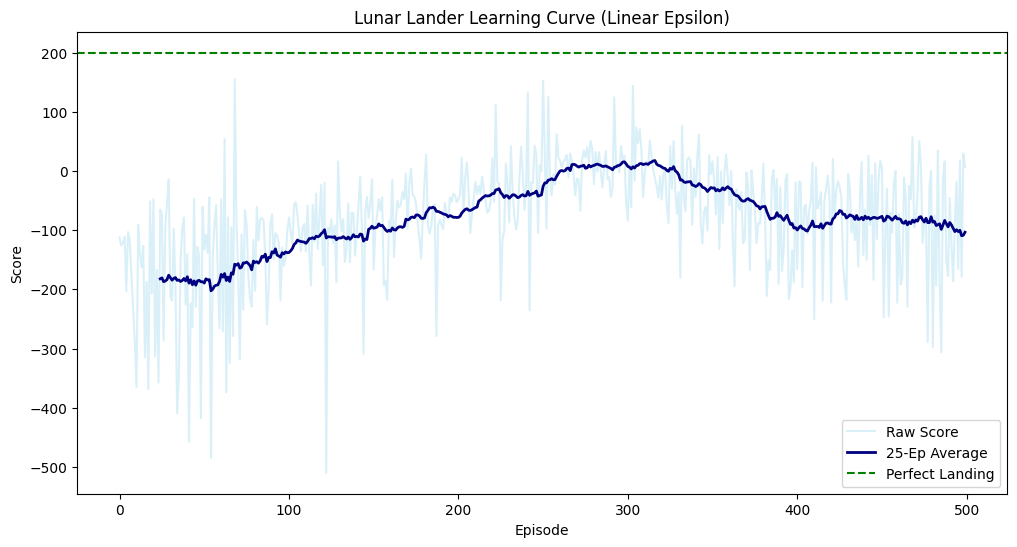

In [33]:
df = pd.DataFrame(history)

# Calculate a 25-episode moving average to see the "true" learning trend
df['rolling_score'] = df['score'].rolling(window=25).mean()

# Quick Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['episode'], df['score'], alpha=0.3, label='Raw Score', color='skyblue')
plt.plot(df['episode'], df['rolling_score'], label='25-Ep Average', color='navy', linewidth=2)
plt.axhline(y=200, color='green', linestyle='--', label='Perfect Landing')
plt.title('Lunar Lander Learning Curve (Linear Epsilon)')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.show()

         phase        mean         std         max
0  Exploration -144.870176  104.666186  155.617878
1     Learning  -28.332264   64.502377  152.519632
2     Refining  -81.211125   82.201303   57.335124


/tmp/ipython-input-3071448924.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df.groupby('phase')['score'].agg(['mean', 'std', 'max']).reset_index()


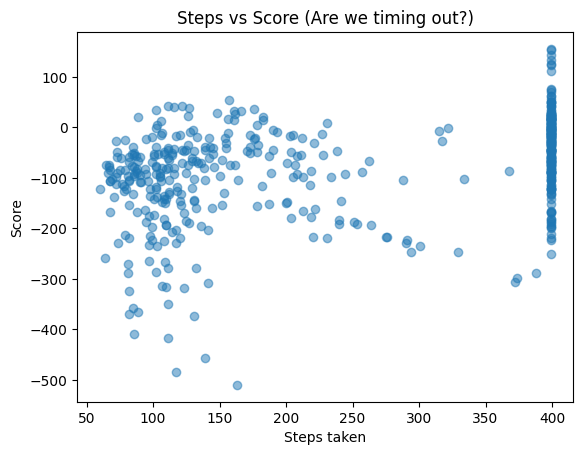

In [34]:
df = pd.DataFrame(history)

# Split into early, mid, and late training
df['phase'] = pd.cut(df['episode'], bins=[0, 150, 350, 500], labels=['Exploration', 'Learning', 'Refining'])

# Check the average score per phase
analysis = df.groupby('phase')['score'].agg(['mean', 'std', 'max']).reset_index()
print(analysis)

# Plot steps vs score - if steps are always 400, it's timing out!
plt.scatter(df['steps'], df['score'], alpha=0.5)
plt.title("Steps vs Score (Are we timing out?)")
plt.xlabel("Steps taken")
plt.ylabel("Score")
plt.show()

#Chronobooks <br>
Three science fiction novels by Prithwis Mukerjee. A dystopian Earth. A technocratic society managed by artificial intelligence. Escape and epiphany on Mars. Can man and machine, carbon and silicon explore and escape into other dimensions of existence? An Indic perspective rooted in Advaita Vedanta and the Divine Feminine.  [More information](http://bit.ly/chrono3) <br>
![alt text](https://blogger.googleusercontent.com/img/a/AVvXsEjsZufX_KYaLwAnJP6bUxvDg5RSPn6r8HIZe749nLWX3RuwyshrYEAUpdw03a9WIWRdnzA9epwJOE05eDJ0Ad7kGyfWiUrC2vNuOskb2jA-e8aOZSx8YqzT8mfZi3E4X1Rz3qlEAiv-aTxlCM976BEeTjx4J64ctY3C_FoV4v9aY_U23F8xRqI5Eg=s1600)